# Imports

In [1]:
from pathlib import Path
from typing import Any, Sequence

from IPython.display import display # type: ignore
import ipywidgets as widgets # type: ignore

import torch
import supervision as sv
from transformers import AutoProcessor, GroundingDinoProcessor, AutoModelForZeroShotObjectDetection # type: ignore
from PIL import Image

import tt

# Setup

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.cuda.empty_cache()
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Using device: cuda
Allocated: 0.00 GB
Reserved: 0.00 GB


In [4]:
data_path = Path.home() / "src/data"
mobs_path = data_path / "mobs1/640"

IMAGE_FILES = sorted(list(mobs_path.iterdir()))
CLASSES = sorted('''
chicken
cow
creeper
enderman
pig
player
sheep
skeleton
spider
villager
zombie
'''.split())

CLASSES_MINECRAFT = [f"minecraft {x}" for x in CLASSES]


In [5]:
viewer = tt.ImageDirViewer(mobs_path)
viewer.show_widget()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=46), Output()), _d…

# Dino

In [ ]:
class Dino:
    model_id = "IDEA-Research/grounding-dino-tiny"
    # model_id = "IDEA-Research/grounding-dino-base"
    
    def __init__(self, classes: Sequence[str], threshold: float, text_threshold: float):
        self.processor: GroundingDinoProcessor = AutoProcessor.from_pretrained(self.model_id)
        self.model = AutoModelForZeroShotObjectDetection.from_pretrained(self.model_id).to(device)

        self.classes = classes
        self.threshold = threshold
        self.text_threshold = text_threshold

    def detect(self, image: Image.Image) -> dict[Any, Any]:
        inputs = self.processor(images=image, text=self.classes, return_tensors="pt").to(self.model.device)
        with torch.no_grad():
            outputs = self.model(**inputs)

        results = self.processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            threshold=self.threshold,
            text_threshold=self.text_threshold,
            target_sizes=[image.size[::-1]]
        )

        result: dict[Any, Any] = results[0]
        display(result)
        for box, score, labels in zip(result["boxes"], result["scores"], result["text_labels"]):
            box = [round(x, 2) for x in box.tolist()]
            print(f"Detected {labels} with confidence {round(score.item(), 3)} at location {box}")

        return result

    def fix_grounding_dino_result(self, result: dict) -> tuple[dict, dict]:
        """Work around bug in grounding dino transformer. result["labels"] are supposed to be ints."""
        # Create label mapping
        unique_labels = list(set(result["text_labels"]))
        label2id = {label: idx for idx, label in enumerate(unique_labels)}
        id2label = {idx: label for label, idx in label2id.items()}
        
        # Fix result
        result_fixed = result.copy()
        result_fixed["labels"] = torch.tensor(
            [label2id[label] for label in result["text_labels"]], 
            device=result["boxes"].device
        )
        
        return result_fixed, id2label

    def infer(self, image_file: str | Path) -> Image.Image:
        image_file = Path(image_file)
        image = Image.open(image_file).convert("RGB")
        result = self.detect(image)

        result_fixed, id2label = self.fix_grounding_dino_result(result)
        detections = sv.Detections.from_transformers(result_fixed, id2label=id2label)
        # Create annotators
        box_annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()

        # Create labels
        labels = [
            f"{label}: {score:.2f}"
            for label, score in zip(result["text_labels"], result["scores"])
        ]

        # Annotate
        annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
        return annotated_image

{'scores': tensor([], device='cuda:0'),
 'boxes': tensor([], device='cuda:0', size=(0, 4)),
 'text_labels': [],
 'labels': []}

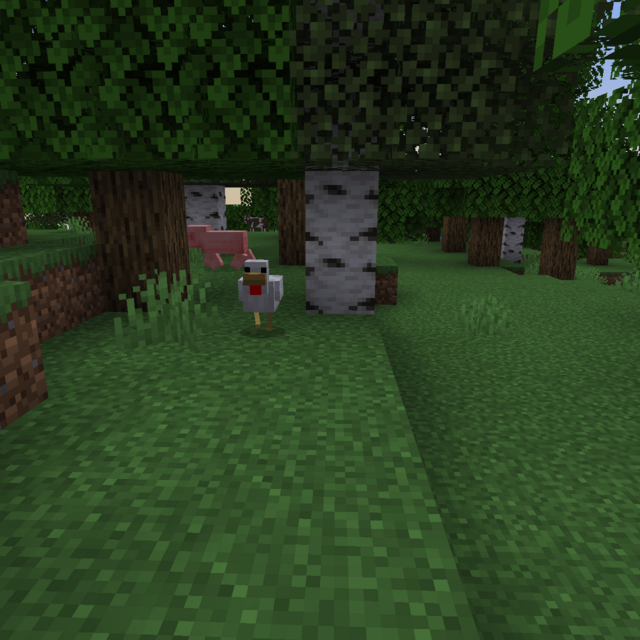

In [29]:
dino1 = Dino(CLASSES, 0.3, 0.5)
fname = mobs_path / '06092b21-2024-10-20_22.22.09.png'
image = dino1.infer(fname)
display(image)

In [ ]:
viewer = tt.InferViewer(dino1.infer, mobs_path)
viewer.show_widget()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=46), Output()), _d…

# YOLO


0: 640x640 1 cow, 49.5ms
Speed: 1.8ms preprocess, 49.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


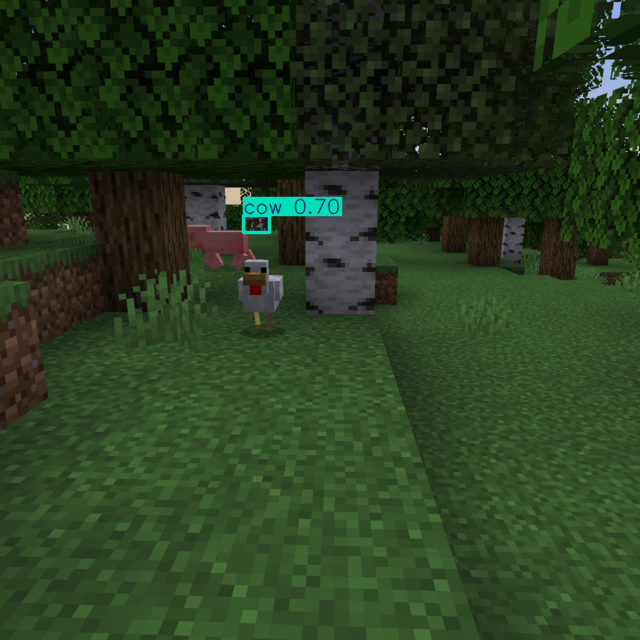

In [6]:
from ultralytics import YOLOWorld

fname = mobs_path / '06092b21-2024-10-20_22.22.09.png'
# Initialize model
model = YOLOWorld("yolov8x-worldv2.pt")  # or yolov8l-worldv2.pt

# Set classes
model.set_classes(["spider", "pig", "minecraft chicken", "cow", "creeper", "zombie", "skeleton"])

# Predict
image = Image.open(fname).convert("RGB")
results = model.predict(image)
annotated_bgr = results[0].plot()
annotated_rgb = annotated_bgr[..., ::-1]
display(Image.fromarray(annotated_rgb))


In [7]:
class Yolo:
    model_id = "yolov8x-worldv2.pt"
    # model_id = "yolov8l-worldv2.pt"
    
    def __init__(self, classes: list[str]):
        self.model = YOLOWorld(self.model_id)
        self.model.set_classes(classes)

    def detect(self, image: Image.Image) -> dict[Any, Any]:
        result = self.model.predict(image)
        return result

    def infer(self, image_file: str | Path) -> Image.Image:
        image_file = Path(image_file)
        image = Image.open(image_file).convert("RGB")
        results = self.detect(image)

        # # Create annotators
        annotated_bgr = results[0].plot()
        annotated_rgb = annotated_bgr[..., ::-1]
        return Image.fromarray(annotated_rgb)

In [ ]:
yolo1 = Yolo(CLASSES)
viewer = tt.InferViewer(yolo1.infer, mobs_path)
viewer.show_widget()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Image:', max=46), Output()), _d…